<div style="text-align: center;">
    <h3>Applied Data Science Project</h3>
    <h2><b>Patient Preferences Studies Classification System</b><h2>
    <h1><b>Design & Test Logistic Regression Classifier Parameters</b></h1>
    <h5>Francesco Giuseppe Gillio</h5>
    <h5>César Augusto Seminario Yrigoyen</h5>
</div>

<div style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/it/4/47/Logo_PoliTo_dal_2021_blu.png" width="250">
</div>

https://github.com/adsp-polito/2024-P8-PPS

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# *Drive* **Setup**

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Patient Preference Studies Binary Classifier
root = 'PPS-BC'

In [4]:
path = os.path.join('/content/drive/MyDrive', root)
if not os.path.exists(path):
    os.makedirs(path)

In [5]:
paths = {
    'input-data': f'{root}/input-data',
    'bert-embeddings': f'{root}/bert-embeddings',
    'notebook-results': f'{root}/notebook-results',
}

In [6]:
for key, value in paths.items():
    path = os.path.join('/content/drive/MyDrive', value)
    if not os.path.exists(path):
        os.makedirs(path)

**Notebook Directory Structure**
```
/PPS-BC
├── /input-data
│   ├── logs.txt
│   ├── clean-articles-2023.csv
│   ├── raw-articles-2023.csv
│   └── /cv-splits
│       ├── /k-fold-2
│       │   ├── fold-1-test.csv
│       │   ├── fold-1-train.csv
│       │   └── ...
│       ├── /k-fold-3
│       │   └── ...
│       ├── /k-fold-5
│       │   └── ...
│       └── ...
├── /bert-embeddings
│   ├── logs.txt
│   ├── /bert-base-uncased
│   │   ├── abstract-text-classification-token.pkl
│   │   ├── abstract-text-hidden-states.pkl
│   │   └── ...
│   ├── /pubmedbert-base-embeddings
│   │   └── ...
│   ├── /S-PubMedBert-MS-MARCO
│   │   └── ...
│   └── ...
└── /notebook-results
    ├── ...
    └── /logistic-regression-params
        ├── /BiomedNLP-BiomedBERT-base-uncased-abstract
        │   └── ...
        └── /pubmedbert-base-embeddings
            └── ...
```

# **Design & Test** *Logistic Regression Classifier* **Parameters**

## *Design & Test* **Requirements**

**Requirements**

In [7]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

from typing import Dict, List, Tuple, Any, Union

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
from itertools import product
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    fbeta_score,
    roc_auc_score,
    average_precision_score,
    log_loss,
    brier_score_loss
)

In [10]:
np.random.seed(42)

In [11]:
device = 'cpu'
device

'cpu'

In [12]:
input = f"/content/drive/MyDrive/{paths['input-data']}"

In [13]:
branch = os.path.join(f"/content/drive/MyDrive/{paths['notebook-results']}", 'logistic-regression-params')
if not os.path.exists(branch):
    os.makedirs(branch)

**Evaluation Metrics**

In [14]:
def compute(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    y_prob: np.ndarray
) -> Dict[str, float]:
    """
    compute classification metrics for predictions

    args:
        y_true (np.ndarray): ground truth labels for the test set
        y_pred (np.ndarray): predictions for the test set
        y_prob (np.ndarray): probabilities for the positive class

    returns:
        Dict[str, float]: a dictionary with classification metrics
    """
    metrics = {
        'F2-PPS': fbeta_score(
            y_true, y_pred, beta=2, pos_label=1
        ),  # F2-Score (Class 1)
        'F1-PPS': f1_score(
            y_true, y_pred, pos_label=1
        ),  # F1-Score (Class 1)

        'TPR': recall_score(
            y_true, y_pred, pos_label=1
        ),  # True Positive Rate (TPR)
        'FNR': 1 - recall_score(
            y_true, y_pred, pos_label=1
        ),  # False Negative Rate (FNR)
        'PPV': precision_score(
            y_true, y_pred, pos_label=1
        ),  # Positive Predictive Value (PPV)
        'FDR': 1 - precision_score(
            y_true, y_pred, pos_label=1
        ),  # False Discovery Rate (FDR)

        'AUC-PR': average_precision_score(
            y_true, y_prob
        ),  # Area Under Precision-Recall Curve (AUC-PR)
        'BA': balanced_accuracy_score(
            y_true, y_pred
        ),  # Balanced Accuracy (BA)
        'AUC-ROC': roc_auc_score(
            y_true, y_prob
        ),  # Area Under ROC Curve (AUC-ROC)

        'G-Mean': np.sqrt(
            recall_score(
                y_true, y_pred, pos_label=1
            ) *
            recall_score(
                y_true, y_pred, pos_label=0
            )
        ),  # Geometric Mean (G-Mean)
        'MCC': matthews_corrcoef(
            y_true, y_pred
        ),  # Matthews Correlation Coefficient (MCC)

        'Log-Loss': log_loss(
            y_true, y_prob
        ),  # Log-Loss
        'BS': brier_score_loss(
            y_true, y_prob
        ),  # Brier Score

        'TNR': recall_score(
            y_true, y_pred, pos_label=0
        ),  # True Negative Rate (TNR)
        'FPR': 1 - recall_score(
            y_true, y_pred, pos_label=0
        ),  # False Positive Rate (FPR)
        'NPV': precision_score(
            y_true, y_pred, pos_label=0
        ),  # Negative Predictive Value (NPV)
        'FOR': 1 - precision_score(
            y_true, y_pred, pos_label=0
        ),  # False Omission Rate (FOR)

        'Accuracy': accuracy_score(
            y_true, y_pred
        ),  # Accuracy
        'Weighted F1-Score': f1_score(
            y_true, y_pred, average='weighted'
        ),  # Weighted F1-Score
        'Weighted Precision': precision_score(
            y_true, y_pred, average='weighted'
        ),  # Weighted Precision
        'Weighted Recall': recall_score(
            y_true, y_pred, average='weighted'
        ),  # Weighted Recall
        'Macro F1-Score': f1_score(
            y_true, y_pred, average='macro'
        ),  # Macro F1-Score
        'Macro Precision': precision_score(
            y_true, y_pred, average='macro'
        ),  # Macro Precision
        'Macro Recall': recall_score(
            y_true, y_pred, average='macro'
        )   # Macro Recall
    }
    return metrics

*Evaluation Metrics Sorting Criteria*

In [15]:
order = [
    'F2-PPS', # F2-Score (Class 1 - Patient Preference Studies)
    'F1-PPS', # F1-Score (Class 1 - Patient Preference Studies)
    'TPR',    # True Positive Rate
    'PPV',    # Positive Predictive Value
    'AUC-PR', # Area Under Precision-Recall Curve
    'BA',     # Balanced Accuracy
    'AUC-ROC' # Area Under ROC Curve
]

**Binary Classification**

In [16]:
def evaluate(
    dir: str,
    loc: str,
    case: str,
    input: str,
    output: str,
    params: Dict[str, List[Union[Tuple[int, ...], str]]],
    order: List[str]
) -> pd.DataFrame:
    """
    evaluate logistic regression classifier parameters for class prediction

    args:
        dir (str): path to the directory with bert-base model
        loc (str): path to file with title-abstract link (.pkl file)
        case (str): cross-validation case identifier (e.g. 'k-fold-2' or 'k-fold-3')
        input (str): path to the input folder with data and splits
        output (str): path to output folder to store logs
        params (Dict[str, List[Union[Tuple[int, ...], str]]]): a dictionary of params
        order (List[str]): evaluation metrics sorting criteria

    returns:
        pd.DataFrame: DataFrame with evaluation results
    """

    def add(
        by: str,
        to: str
    ) -> pd.DataFrame:
        """
        add an embeddings column to the input split file

        args:
            by (str): path to the .pkl file with embeddings
            to (str): path to the .csv split file
        """
        dataset = pd.read_pickle(by)
        frame = pd.read_csv(to)
        embeddings = [
            column for column in dataset.columns
            if column not in ['title', 'abstract', 'label']
        ]
        data = frame.merge(
            dataset[['title', 'abstract', 'label'] + embeddings],
            on=['title', 'abstract', 'label'],
            how='left'
        )
        return data

    def collect(
        dir: str
    ) -> List[Tuple[str, str]]:
        """
        collect train and test file pairs from the directory

        args:
            dir (str): path to the directory with train/test files

        returns:
            List[Tuple[str, str]]: list of (train file, test file) tuples
        """
        files = {'train': [], 'test': []}
        for idx, _, walk in os.walk(dir):
            for file in walk:
                if file.endswith('.csv'):
                    if 'train' in file:
                        files['train'].append(
                            os.path.join(idx, file)
                        )
                    elif 'test' in file:
                        files['test'].append(
                            os.path.join(idx, file)
                        )
        files['train'].sort()
        files['test'].sort()
        return list(zip(files['train'], files['test']))

    log = f'\n{case}\n'
    with open(os.path.join(output, 'logs.txt'), 'a') as file:
        file.write(log + '\n')
    combinations = [
        {'C': x,
         'solver': y}
        for x, y in product(
             params['C'],
             params['solver']
        )
    ]
    steps = len(combinations) * len(
        collect(
            os.path.join(input, 'cv-splits', case)
        )
    )
    progress = 0
    results = list()
    print(f"processing {case}...")
    for params in combinations:
        log = f'-' * 50 + '\n' + f'Logistic Regression Classifier Parameters: {params}\n' + f'-' * 50 + '\n'
        with open(os.path.join(output, 'logs.txt'), 'a') as file:
            file.write(log + '\n')
        averages = {}
        route = os.path.join(input, 'cv-splits', case)
        for files in collect(route):
            progress += 1
            percentage = (progress / steps) * 100
            sys.stdout.write(f"\revaluating logistic regression classifier parameters... {percentage:.2f}%")
            sys.stdout.flush()
            log = f'classifier execution on:\n- train file: {os.path.basename(files[0])}\n- test file: {os.path.basename(files[1])}'
            with open(os.path.join(output, 'logs.txt'), 'a') as file:
                file.write(log + '\n')
            embeddings = os.path.join(dir, loc)
            data_train = add(
                by=embeddings,
                to=files[0]
            )
            data_test = add(
                by=embeddings,
                to=files[1]
            )
            y_train = data_train['label']
            y_test = np.array(data_test['label'].tolist())
            # skip non-embedding columns
            column = [
                column for column in data_train.columns
                if column not in ['label', 'title', 'abstract']
            ][0]
            if not isinstance(data_train[column].values[0], np.ndarray):
                # debug
                print(f'WARNING: {column} not of type np.ndarray')
                continue
            x_train = np.array(data_train[column].tolist())
            x_test = np.array(data_test[column].tolist())
            try:
                logit = LogisticRegression(
                    penalty="l2",
                    class_weight="balanced",
                    random_state=42,
                    max_iter=1000,
                    **params
                )
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('classifier', logit)
                ])
                # train
                pipeline.fit(x_train, y_train)
                # test
                y_pred = pipeline.predict(x_test)
                y_prob = pipeline.predict_proba(x_test)
                metrics = compute(
                    y_true=y_test,
                    y_pred=y_pred,
                    y_prob=y_prob[:, 1]
                )
                for metric in ['F2-PPS', 'F1-PPS', 'TPR', 'PPV']:
                    log = f"{metric}: {metrics[metric]}"
                    with open(os.path.join(output, 'logs.txt'), 'a') as file:
                        file.write(log + '\n')
            except Exception as e:
                # debug
                print(f'ERROR for {column}: {e}')
                continue
            if str(params) not in averages:
                averages[str(params)] = {
                    key: [] for key in metrics
                }
            for key, value in metrics.items():
                averages[str(params)][key].append(value)
        for param, scores in averages.items():
            mean = {
                key: np.mean(values)
                for key, values in scores.items()
            }
            results.append({
                'Logistic Regression Parameters': param,
                **mean
            })
            for idx, metric in enumerate(['F2-PPS', 'F1-PPS', 'TPR', 'PPV']):
                log = ('\n' if idx == 0 else '') + metric + ': ' + str(mean[metric])
                with open(os.path.join(output, 'logs.txt'), 'a') as file:
                    file.write(log + '\n')
    print()
    data = pd.DataFrame(results)
    data = data.sort_values(
        by=order,
        ascending=[False] * len(order)
    )
    return data

*Statistical* **Data Analysis**

In [17]:
def combine(
    dir: str,
    main: List[str],
    order: List[str]
) -> pd.DataFrame:
    """
    combine multiple .csv files into a single DataFrame

    args:
        dir (str): path to the folder with .csv files
        main (List[str]): main group-by columns
        order (List[str]): evaluation metrics sorting criteria

    returns:
        pd.DataFrame: DataFrame with scores
    """
    files = glob.glob(os.path.join(dir, "*.csv"))
    data = list()
    for file in files:
        frame = pd.read_csv(file)
        data.append(frame)
    concat = pd.concat(data)
    data = (
        concat.groupby(main)
        .agg(
            ['mean', 'std']
        )
        .reset_index()
    )
    data.columns = [
        '-'.join(column).strip('-') for column in data.columns
        if column not in main
    ]
    for column in data.columns:
        if column.endswith('-mean'):
            base = column.rsplit('-', 1)[0]
            deviation = f'{base}-std'
            if deviation in data.columns:
                # compute confidence interval
                N = len(concat.groupby(main))
                sem = data[deviation] / np.sqrt(N)
                deg = N - 1
                # 99% confidence level
                critical = stats.t.ppf(0.995, deg)
                lower = data[column] - critical * sem
                upper = data[column] + critical * sem
                data[f'{base}-ci'] = (
                    data[column].round(3).astype(str) + " ± " +
                    ((upper - lower) / 2).round(3).astype(str)
                )
    data = data.sort_values(
        by=[f"{metric}-mean" for metric in order],
        ascending=[False] * len(order)
    )
    columns = [
        column for column in data.columns
        if column.endswith('-ci')
    ]
    data = data[main + columns]
    data.columns = [
        column.replace('-ci', '') for column in data.columns
    ]
    return data

In [18]:
def get(
    data: pd.DataFrame,
    case: str,
    order: List[str]
) -> pd.DataFrame:
    """
    get a dataframe by group-by on input column

    args:
        data (pd.DataFrame): DataFrame with evaluation results
        case (str): group-by column to plot (e.g., 'BERT-Base Model')
        order (List[str]): evaluation metrics sorting criteria

    returns:
        pd.DataFrame: DataFrame with scores
    """
    data = data[[case] + order].copy()
    for metric in order:
        data[metric] = data[metric].str.extract(r'(\d+\.\d+)').astype(float)
    res = (
        data.groupby(case)
        .agg(
            ['mean', 'std']
        )
        .reset_index()
    )
    res.columns = [
        '-'.join(column).strip('-') for column in res.columns
        if column not in [case]
    ]
    for column in res.columns:
        if column.endswith('-mean'):
            base = column.rsplit('-', 1)[0]
            deviation = f'{base}-std'
            if deviation in res.columns:
                # compute confidence interval
                N = len(data.groupby([case]))
                sem = res[deviation] / np.sqrt(N)
                deg = N - 1
                # 99% confidence level
                critical = stats.t.ppf(0.995, deg)
                lower = res[column] - critical * sem
                upper = res[column] + critical * sem
                res[f'{base}-ci'] = (
                    res[column].round(3).astype(str) + " ± " +
                    ((upper - lower) / 2).round(3).astype(str)
                )
    res = res.sort_values(
        by=[f"{metric}-mean" for metric in order],
        ascending=[False] * len(order)
    )
    columns = [
        column for column in res.columns
        if column.endswith('-ci')
    ]
    res = res[[case] + columns]
    res.columns = [
        column.replace('-ci', '') for column in res.columns
    ]
    return res

In [19]:
def plot(
    data: pd.DataFrame,
    column: str,
    output: str,
    order: List[str]
) -> None:
    """
    plot performance metrics with confidence intervals

    args:
        data (pd.DataFrame): DataFrame with evaluation results
        column (str): group-by column to plot (e.g., 'BERT-Base Model')
        output (str): path to output folder to store plot
        order (List[str]): evaluation metrics sorting criteria
    """
    chart = list()
    for metric in order:
        if metric in data.columns:
            for _, row in data.iterrows():
                ci = row[metric].split(' ± ')
                mean = float(ci[0])
                error = float(ci[1])
                chart.append({
                    column: row[column],
                    'Metric': metric,
                    'Mean': mean,
                    'Error': error
                })
    chart = pd.DataFrame(chart)
    chart[column] = chart[column].astype(str)
    plt.figure(figsize=(16, 9))
    position = -0.75
    ax = sns.barplot(
        chart,
        x=column,
        y='Mean',
        hue='Metric',
        ci=None,
        palette='crest'
    )
    for bar, (_, row) in zip(ax.patches, chart.iterrows()):
        center = bar.get_x() + bar.get_width() / 2
        lower = row['Mean'] - row['Error']
        upper = row['Mean'] + row['Error']
        plt.errorbar(
            x=center,
            y=row['Mean'],
            yerr=row['Error'],
            fmt='none',
            color='black',
            linestyle='-',
            linewidth=0.5
        )
    for idx, metric in enumerate(chart['Metric'].unique()):
        columns = chart[chart['Metric'] == metric]
        row = columns.loc[columns['Mean'].idxmax()]
        value = row['Mean']
        center = (
            ax.patches[
                chart.index.get_loc(row.name)
            ].get_x() +
            ax.patches[
                chart.index.get_loc(row.name)
            ].get_width() / 2
        )
        if metric == 'F2-PPS':
            ax.plot(
                [center, position],
                [value, value],
                color='black',
                linestyle='--',
                linewidth=0.5
            )
            ax.text(
                x=position,
                y=value,
                s=f'{value:.3f}',
                ha='right',
                va='center',
                fontsize=10
            )
    plt.title(
        f'{column} Performance Distributions',
        fontsize=15
    )
    plt.xlabel(
        column,
        fontsize=10
    )
    plt.ylabel(
        'Metric Value',
        fontsize=10
    )
    plt.legend(
        title=f'Metric',
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode='anchor'
    )
    plt.ylim(
        bottom=min(
            chart['Mean'] - chart['Error']
        )
    )
    plt.tight_layout()
    plt.savefig(
        f'{output}/{column.lower().replace(" ", "-")}-performance-plot.png',
        dpi=300,
        bbox_inches='tight'
    )
    plt.show()

*What to* **Move Forward**

In [20]:
def select(
    dir: str,
    title: str,
    column: str,
    output: str,
    main: List[str],
    order: List[str],
    model: Dict[str, str] = None
) -> pd.DataFrame:
    """
    what to move forward

    args:
        dir (str): path to the folder with .csv file
        title (str): plot title
        column (str): group-by column to plot (e.g., 'BERT-Base Model')
        output (str): path to output folder to store plot
        main (List[str]): main group-by columns
        order (List[str]): evaluation metrics sorting criteria
        model (Dict[str, str], optional): dictionary with {'BERT-Base Model': 'bert-base model'} to filter

    returns:
        pd.DataFrame: DataFrame with scores
    """
    data = pd.read_csv(dir)
    data = data[main + order]
    if model:
        key, value = next(iter(model.items()))
        data = data[data[key] == value]
    def lower(value):
        base, error = map(float, value.split(' ± '))
        return base - error
    for metric in order:
        data[metric] = data[metric].apply(lower)
    data = data.sort_values(
        by=order,
        ascending=[False] * len(order)
    )
    data.to_csv(os.path.join(output, f'{title.lower().replace(" ", "-")}-ranks.csv'), encoding='utf-8', index=False)
    chart = []
    for metric in order:
        if metric in data.columns:
            for _, row in data.iterrows():
                mean = float(row[metric])
                chart.append({
                    column: row[column],
                    'Metric': metric,
                    'Mean': mean
                })
    chart = pd.DataFrame(chart)
    chart[column] = chart[column].astype(str)
    plt.figure(figsize=(16, 9))
    position = -0.75
    ax = sns.barplot(
        chart,
        x=column,
        y='Mean',
        hue='Metric',
        palette='crest'
    )
    for idx, metric in enumerate(chart['Metric'].unique()):
        columns = chart[chart['Metric'] == metric]
        row = columns.loc[columns['Mean'].idxmax()]
        value = row['Mean']
        center = (
            ax.patches[
                chart.index.get_loc(row.name)
            ].get_x() +
            ax.patches[
                chart.index.get_loc(row.name)
            ].get_width() / 2
        )
        if metric == 'F2-PPS':
            ax.plot(
                [center, position],
                [value, value],
                color='black',
                linestyle='--',
                linewidth=0.5
            )
            ax.text(
                x=position,
                y=value,
                s=f'{value:.3f}',
                ha='right',
                va='center',
                fontsize=10
            )
    plt.title(
        f'{title} Performance Distributions',
        fontsize=15
    )
    plt.xlabel(
        column,
        fontsize=10
    )
    plt.ylabel(
        'Metric Value',
        fontsize=10
    )
    plt.legend(
        title=f'Metric',
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode='anchor'
    )
    plt.ylim(
        bottom=min(
            chart['Mean']
        )
    )
    plt.tight_layout()
    plt.savefig(
        f'{output}/{title.lower().replace(" ", "-")}-performance-plot.png',
        dpi=300,
        bbox_inches='tight'
    )
    plt.show()
    return data

## **Design & Test** *Logistic Regression Classifier* **Parameters** for **BiomedNLP-BiomedBERT-base-uncased-abstract**

*BiomedNLP-BiomedBERT-base-uncased-abstract*

In [21]:
output = os.path.join(branch, 'BiomedNLP-BiomedBERT-base-uncased-abstract')
if not os.path.exists(output):
    os.makedirs(output)

In [22]:
with open(os.path.join(output, 'logs.txt'), 'w') as file:
    pass

**BERT-Base Model:** *BiomedNLP-BiomedBERT-base-uncased-abstract*

In [23]:
model = os.path.join(f"/content/drive/MyDrive/{paths['bert-embeddings']}", 'BiomedNLP-BiomedBERT-base-uncased-abstract')

**T&A Link:** *vector-weighted-average-2080-hidden-states*

In [24]:
link = 'vector-weighted-average-2080-hidden-states.pkl'

**Logistic Regression Classifier Parameters**

In [25]:
params = {
    'C': [
        1e0, 1e1, 1e2
    ],
    'solver': [
        'sag',
        'lbfgs',
        'liblinear',
        'newton-cg',
        'newton-cholesky'
    ]
}

*Fibonacci Sequence:* **[2, 3, 5, 8, 13, 21]**

Splits: **[2 + 3 + 21]** & **[5 + 8 + 13]**

*Split into 2 blocks of 26 iterations for* **M** *configurations, with* **M = 15** *parameter combinations*

*Computational effort per split:* **Mx26 = 15x26=390** *iterations on* **1.215** *data points each*

In [26]:
for seed in [2, 3, 21]:
    results = evaluate(
        dir = model,
        loc = link,
        case = f'k-fold-{seed}',
        input = input,
        output = output,
        params = params,
        order = order
    )
    results.to_csv(os.path.join(output, f'k-fold-{seed}-results.csv'), index=False)

processing k-fold-2...
evaluating logistic regression classifier parameters... 100.00%
processing k-fold-3...
evaluating logistic regression classifier parameters... 100.00%
processing k-fold-21...
evaluating logistic regression classifier parameters... 100.00%


In [27]:
for seed in [5, 8, 13]:
    results = evaluate(
        dir = model,
        loc = link,
        case = f'k-fold-{seed}',
        input = input,
        output = output,
        params = params,
        order = order
    )
    results.to_csv(os.path.join(output, f'k-fold-{seed}-results.csv'), index=False)

processing k-fold-5...
evaluating logistic regression classifier parameters... 100.00%
processing k-fold-8...
evaluating logistic regression classifier parameters... 100.00%
processing k-fold-13...
evaluating logistic regression classifier parameters... 100.00%


**Global** *Statistical Data Analysis*

In [28]:
results = combine(
    dir = output,
    main = ['Logistic Regression Parameters'],
    order = order
)
results.head()

,Logistic Regression Parameters,F2-PPS,F1-PPS,TPR,FNR,PPV,FDR,AUC-PR,BA,AUC-ROC,...,FPR,NPV,FOR,Accuracy,Weighted F1-Score,Weighted Precision,Weighted Recall,Macro F1-Score,Macro Precision,Macro Recall
1,"{'C': 1.0, 'solver': 'liblinear'}",0.921 ± 0.004,0.904 ± 0.011,0.934 ± 0.005,0.066 ± 0.005,0.881 ± 0.023,0.119 ± 0.023,0.964 ± 0.003,0.951 ± 0.003,0.989 ± 0.001,...,0.031 ± 0.007,0.985 ± 0.001,0.015 ± 0.001,0.963 ± 0.005,0.963 ± 0.005,0.965 ± 0.004,0.963 ± 0.005,0.94 ± 0.007,0.933 ± 0.011,0.951 ± 0.003
14,"{'C': 100.0, 'solver': 'sag'}",0.921 ± 0.004,0.907 ± 0.011,0.931 ± 0.006,0.069 ± 0.006,0.887 ± 0.024,0.113 ± 0.024,0.963 ± 0.003,0.951 ± 0.003,0.988 ± 0.001,...,0.029 ± 0.007,0.984 ± 0.001,0.016 ± 0.001,0.964 ± 0.005,0.964 ± 0.005,0.966 ± 0.004,0.964 ± 0.005,0.942 ± 0.007,0.936 ± 0.012,0.951 ± 0.003
9,"{'C': 10.0, 'solver': 'sag'}",0.92 ± 0.006,0.907 ± 0.011,0.929 ± 0.008,0.071 ± 0.008,0.89 ± 0.023,0.11 ± 0.023,0.963 ± 0.003,0.951 ± 0.003,0.988 ± 0.001,...,0.028 ± 0.007,0.984 ± 0.002,0.016 ± 0.002,0.964 ± 0.005,0.964 ± 0.004,0.966 ± 0.004,0.964 ± 0.005,0.942 ± 0.007,0.937 ± 0.011,0.951 ± 0.003
4,"{'C': 1.0, 'solver': 'sag'}",0.916 ± 0.003,0.909 ± 0.007,0.923 ± 0.005,0.077 ± 0.005,0.899 ± 0.018,0.101 ± 0.018,0.964 ± 0.004,0.949 ± 0.002,0.989 ± 0.001,...,0.025 ± 0.005,0.982 ± 0.001,0.018 ± 0.001,0.965 ± 0.003,0.965 ± 0.003,0.967 ± 0.003,0.965 ± 0.003,0.944 ± 0.005,0.941 ± 0.009,0.949 ± 0.002
6,"{'C': 10.0, 'solver': 'liblinear'}",0.912 ± 0.004,0.898 ± 0.006,0.923 ± 0.009,0.077 ± 0.009,0.88 ± 0.019,0.12 ± 0.019,0.962 ± 0.003,0.946 ± 0.002,0.988 ± 0.001,...,0.031 ± 0.005,0.982 ± 0.002,0.018 ± 0.002,0.961 ± 0.003,0.961 ± 0.003,0.963 ± 0.003,0.961 ± 0.003,0.937 ± 0.004,0.931 ± 0.009,0.946 ± 0.002


In [29]:
results.to_csv(os.path.join(output, f'ranks.csv'), encoding='utf-8', index=False)

**Local** *Statistical Data Analysis* - **by Logistic Regression Classifier Parameters**

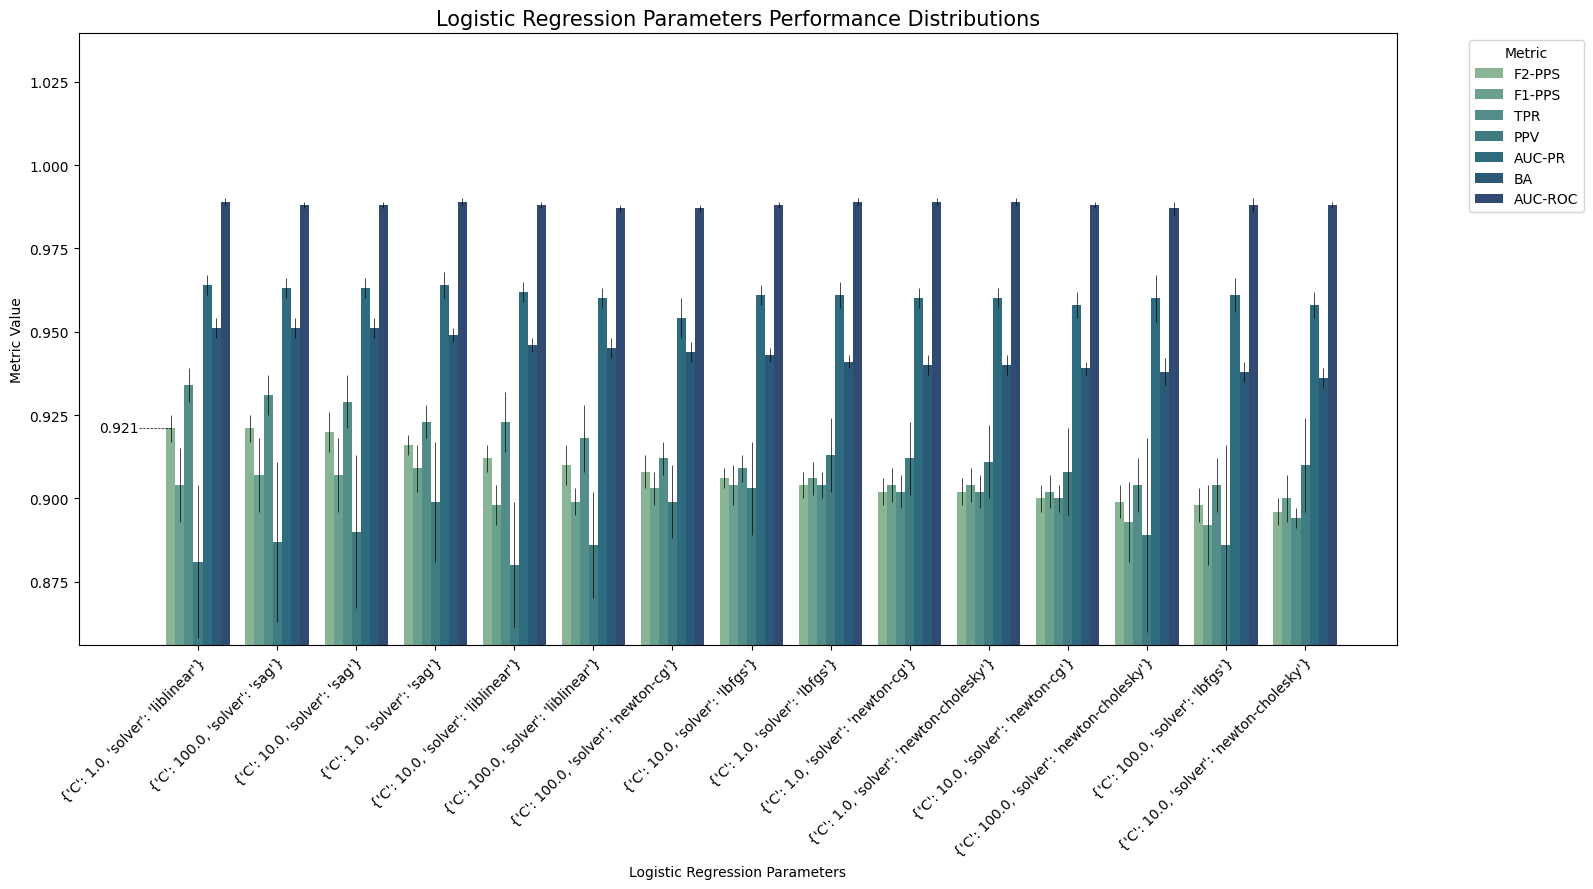

In [30]:
frame = results[['Logistic Regression Parameters'] + order].copy()

plot(frame, 'Logistic Regression Parameters', output, order)

* Select the **Logistic Regression Classifier Parameters** with the *highest performance at the lower bound of the confidence interval*

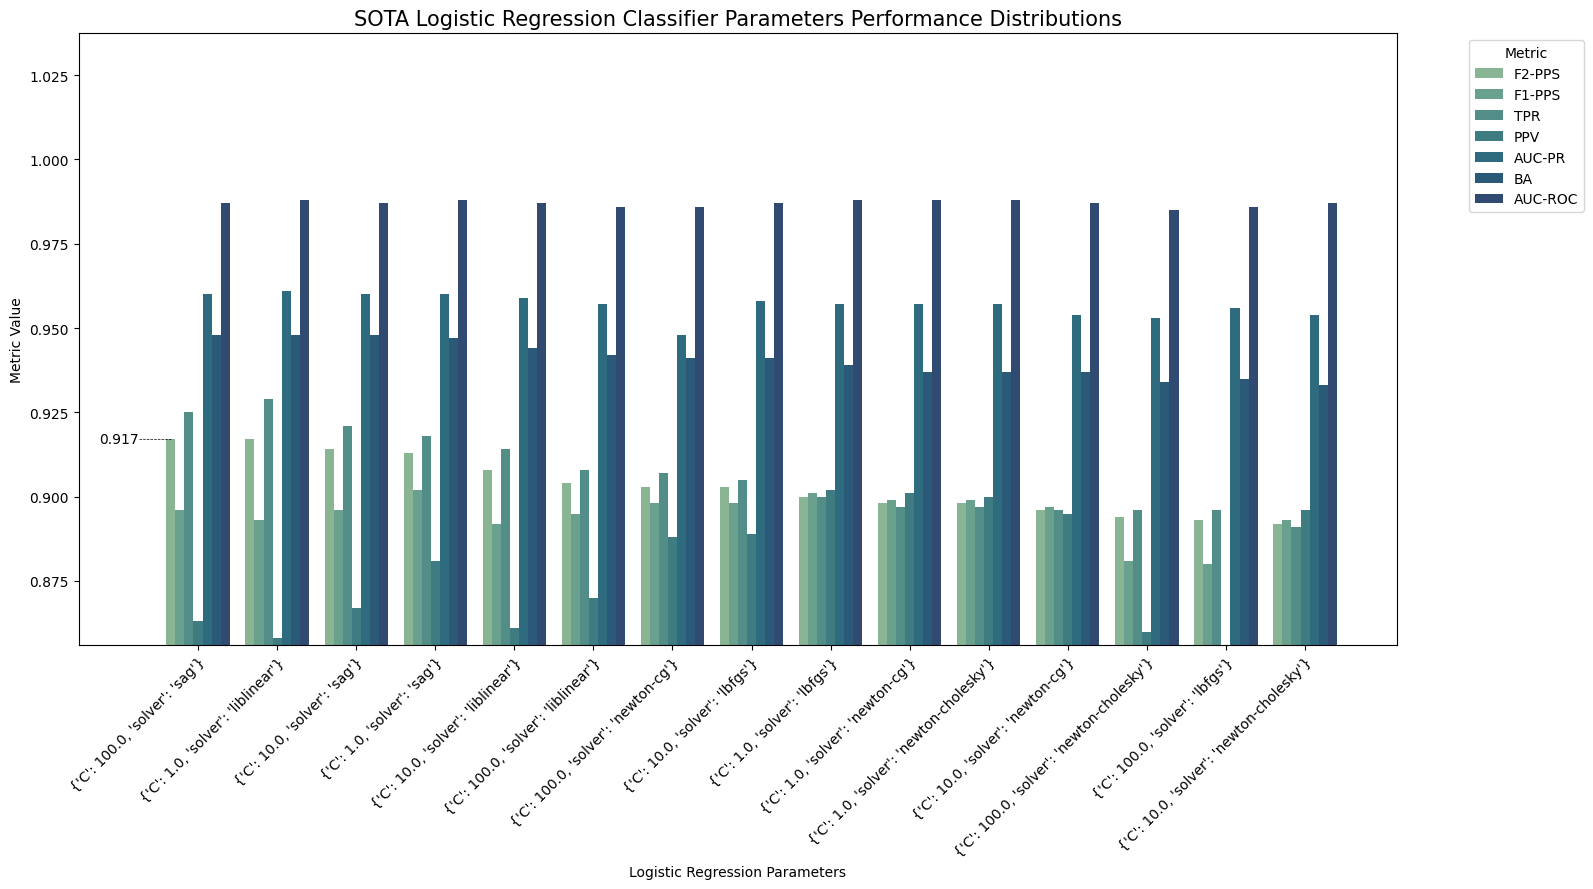

In [31]:
base = select(
    dir = os.path.join(output, f'ranks.csv'),
    title = "SOTA Logistic Regression Classifier Parameters",
    column = 'Logistic Regression Parameters',
    output = output,
    main = ['Logistic Regression Parameters'],
    order = order,
    model = None
)

## **Design & Test** *Logistic Regression Classifier* **Parameters** for **pubmedbert-base-embeddings**

*pubmedbert-base-embeddings*

In [32]:
output = os.path.join(branch, 'pubmedbert-base-embeddings')
if not os.path.exists(output):
    os.makedirs(output)

In [33]:
with open(os.path.join(output, 'logs.txt'), 'w') as file:
    pass

**BERT-Base Model:** *pubmedbert-base-embeddings*

In [34]:
model = os.path.join(f"/content/drive/MyDrive/{paths['bert-embeddings']}", 'pubmedbert-base-embeddings')

**T&A Link:** *vector-concatenation-classification-token*

In [35]:
link = 'vector-concatenation-classification-token.pkl'

**Logistic Regression Classifier Parameters**

In [36]:
params = {
    'C': [
        1e0, 1e1, 1e2
    ],
    'solver': [
        'sag',
        'lbfgs',
        'liblinear',
        'newton-cg',
        'newton-cholesky'
    ]
}

*Fibonacci Sequence:* **[2, 3, 5, 8, 13, 21]**

Splits: **[2 + 3 + 21]** & **[5 + 8 + 13]**

*Split into 2 blocks of 26 iterations for* **M** *configurations, with* **M = 15** *parameter combinations*

*Computational effort per split:* **Mx26 = 15x26=390** *iterations on* **1.215** *data points each*

In [37]:
for seed in [2, 3, 21]:
    results = evaluate(
        dir = model,
        loc = link,
        case = f'k-fold-{seed}',
        input = input,
        output = output,
        params = params,
        order = order
    )
    results.to_csv(os.path.join(output, f'k-fold-{seed}-results.csv'), index=False)

processing k-fold-2...
evaluating logistic regression classifier parameters... 100.00%
processing k-fold-3...
evaluating logistic regression classifier parameters... 100.00%
processing k-fold-21...
evaluating logistic regression classifier parameters... 100.00%


In [38]:
for seed in [5, 8, 13]:
    results = evaluate(
        dir = model,
        loc = link,
        case = f'k-fold-{seed}',
        input = input,
        output = output,
        params = params,
        order = order
    )
    results.to_csv(os.path.join(output, f'k-fold-{seed}-results.csv'), index=False)

processing k-fold-5...
evaluating logistic regression classifier parameters... 100.00%
processing k-fold-8...
evaluating logistic regression classifier parameters... 100.00%
processing k-fold-13...
evaluating logistic regression classifier parameters... 100.00%


**Global** *Statistical Data Analysis*

In [39]:
results = combine(
    dir = output,
    main = ['Logistic Regression Parameters'],
    order = order
)
results.head()

,Logistic Regression Parameters,F2-PPS,F1-PPS,TPR,FNR,PPV,FDR,AUC-PR,BA,AUC-ROC,...,FPR,NPV,FOR,Accuracy,Weighted F1-Score,Weighted Precision,Weighted Recall,Macro F1-Score,Macro Precision,Macro Recall
4,"{'C': 1.0, 'solver': 'sag'}",0.906 ± 0.009,0.884 ± 0.005,0.922 ± 0.013,0.078 ± 0.013,0.853 ± 0.015,0.147 ± 0.015,0.958 ± 0.005,0.942 ± 0.005,0.986 ± 0.002,...,0.038 ± 0.004,0.982 ± 0.003,0.018 ± 0.003,0.954 ± 0.002,0.955 ± 0.002,0.957 ± 0.002,0.954 ± 0.002,0.928 ± 0.003,0.917 ± 0.006,0.942 ± 0.005
1,"{'C': 1.0, 'solver': 'liblinear'}",0.905 ± 0.006,0.865 ± 0.013,0.935 ± 0.011,0.065 ± 0.011,0.808 ± 0.029,0.192 ± 0.029,0.957 ± 0.006,0.941 ± 0.004,0.985 ± 0.002,...,0.053 ± 0.01,0.985 ± 0.002,0.015 ± 0.002,0.944 ± 0.007,0.946 ± 0.006,0.951 ± 0.004,0.944 ± 0.007,0.915 ± 0.009,0.896 ± 0.014,0.941 ± 0.004
9,"{'C': 10.0, 'solver': 'sag'}",0.904 ± 0.006,0.868 ± 0.014,0.931 ± 0.011,0.069 ± 0.011,0.816 ± 0.031,0.184 ± 0.031,0.954 ± 0.005,0.94 ± 0.004,0.985 ± 0.002,...,0.051 ± 0.01,0.984 ± 0.002,0.016 ± 0.002,0.946 ± 0.007,0.947 ± 0.006,0.952 ± 0.005,0.946 ± 0.007,0.917 ± 0.009,0.9 ± 0.015,0.94 ± 0.004
14,"{'C': 100.0, 'solver': 'sag'}",0.904 ± 0.005,0.865 ± 0.015,0.933 ± 0.011,0.067 ± 0.011,0.81 ± 0.033,0.19 ± 0.033,0.954 ± 0.005,0.94 ± 0.003,0.985 ± 0.002,...,0.053 ± 0.011,0.984 ± 0.002,0.016 ± 0.002,0.944 ± 0.007,0.946 ± 0.007,0.951 ± 0.005,0.944 ± 0.007,0.915 ± 0.01,0.897 ± 0.016,0.94 ± 0.003
6,"{'C': 10.0, 'solver': 'liblinear'}",0.903 ± 0.008,0.869 ± 0.015,0.929 ± 0.013,0.071 ± 0.013,0.821 ± 0.032,0.179 ± 0.032,0.956 ± 0.006,0.94 ± 0.005,0.985 ± 0.002,...,0.049 ± 0.01,0.983 ± 0.003,0.017 ± 0.003,0.947 ± 0.007,0.948 ± 0.006,0.953 ± 0.005,0.947 ± 0.007,0.918 ± 0.01,0.902 ± 0.015,0.94 ± 0.005


In [40]:
results.to_csv(os.path.join(output, f'ranks.csv'), encoding='utf-8', index=False)

**Local** *Statistical Data Analysis* - **by Logistic Regression Classifier Parameters**

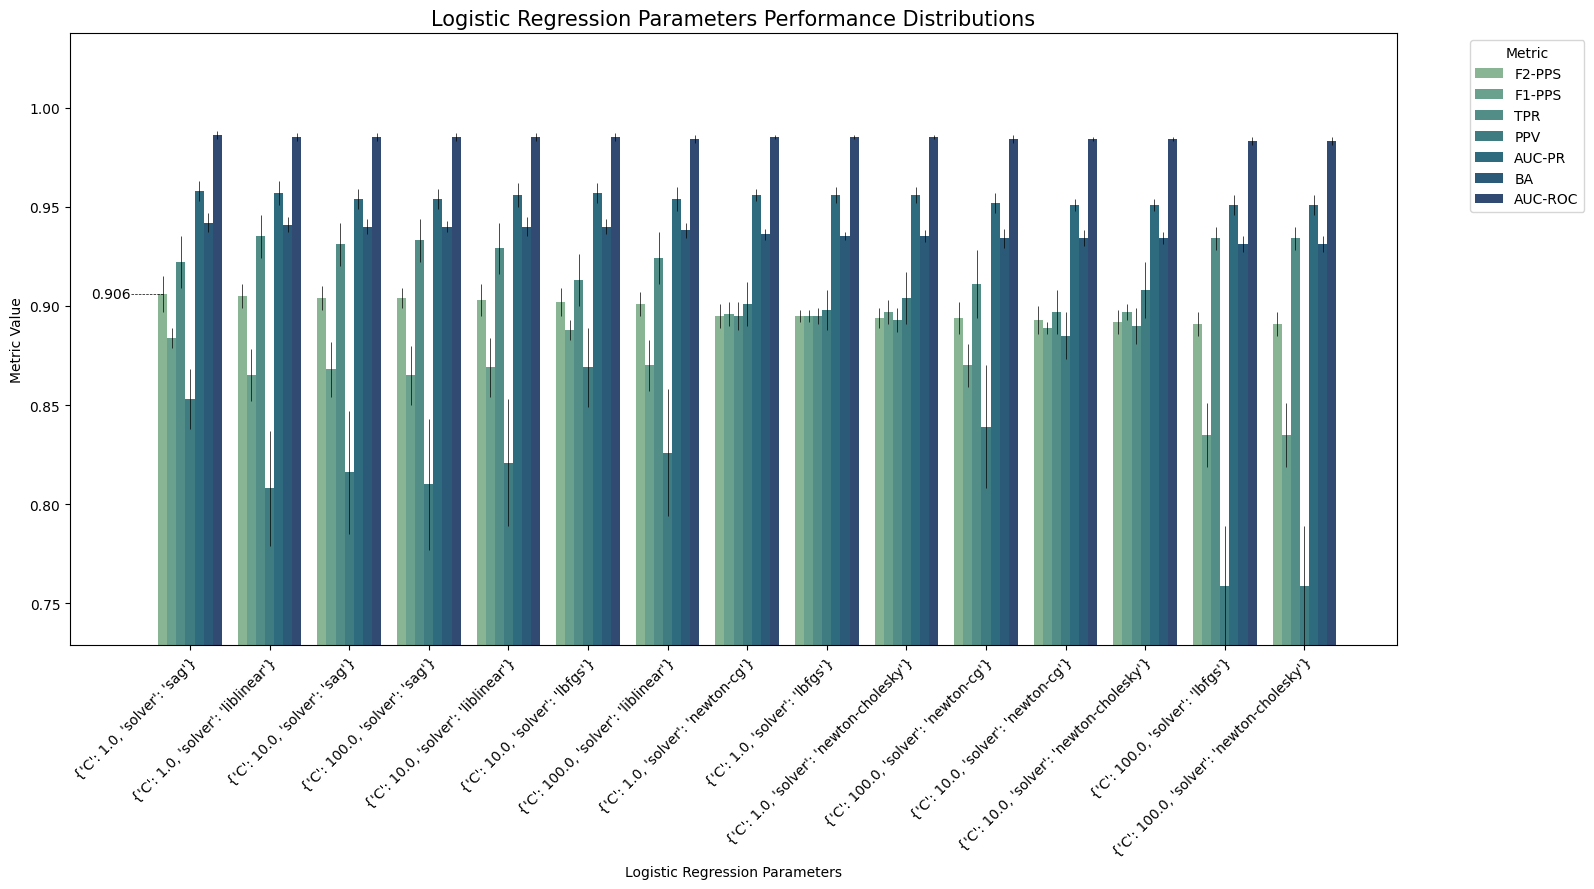

In [41]:
frame = results[['Logistic Regression Parameters'] + order].copy()

plot(frame, 'Logistic Regression Parameters', output, order)

* Select the **Logistic Regression Classifier Parameters** with the *highest performance at the lower bound of the confidence interval*

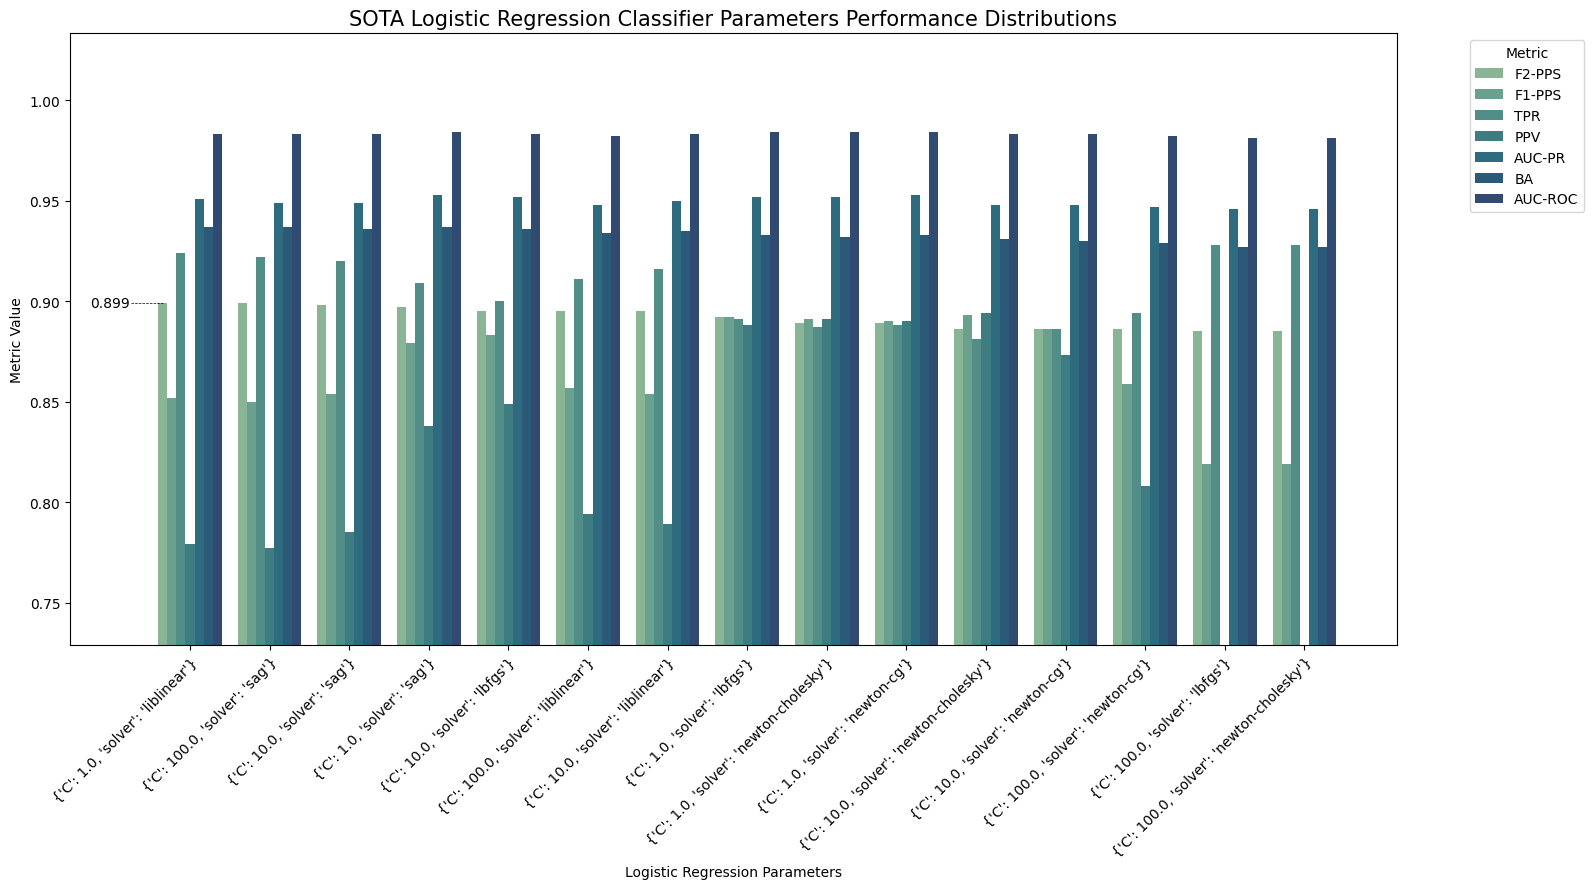

In [42]:
base = select(
    dir = os.path.join(output, f'ranks.csv'),
    title = "SOTA Logistic Regression Classifier Parameters",
    column = 'Logistic Regression Parameters',
    output = output,
    main = ['Logistic Regression Parameters'],
    order = order,
    model = None
)